In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv("/content/clean_data.csv")
df.head()

,Unnamed: 0,date,total_cases,new_cases,total_deaths,new_deaths,new_tests,new_tests_reg
0,29,2020-02-19,2.0,2.0,2.0,2.0,10418.0,14565.162432
1,30,2020-02-20,5.0,3.0,2.0,0.0,10418.0,14565.162432
2,31,2020-02-21,18.0,13.0,4.0,2.0,10418.0,14565.162435
3,32,2020-02-22,28.0,10.0,5.0,1.0,10418.0,14565.162453
4,33,2020-02-23,43.0,15.0,8.0,3.0,10418.0,14565.162521


In [41]:
df.shape

(790, 8)

In [42]:
train_size_per = 0.9
train_size = df.shape[0] * train_size_per
test_size = df.shape[0] - train_size 
print (f"train_size : {train_size}, test_size : {test_size}")

train_size : 711.0, test_size : 79.0


In [43]:
df.drop('date', axis=1, inplace = True)
df.drop('total_cases', axis=1, inplace = True)
df.drop('total_deaths', axis=1, inplace = True)
df.drop('new_deaths', axis=1, inplace = True)
df.drop('new_tests', axis=1, inplace = True)
df.drop('Unnamed: 0', axis=1, inplace = True)
df.head()

,new_cases,new_tests_reg
0,2.0,14565.162432
1,3.0,14565.162432
2,13.0,14565.162435
3,10.0,14565.162453
4,15.0,14565.162521


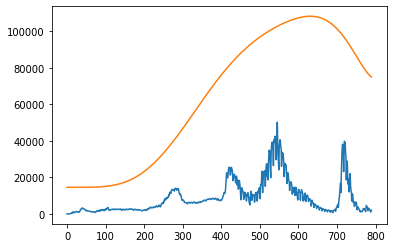

In [44]:
plt.plot(df.index, df['new_cases'])
plt.plot(df.index, df['new_tests_reg'])

In [45]:
df.drop('new_tests_reg', axis=1, inplace=True)

In [46]:
df.head()

,new_cases
0,2.0
1,3.0
2,13.0
3,10.0
4,15.0


In [47]:
train = df[:760]
test = df[760:]

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [49]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(n_input, n_features), return_sequences = True))
model.add(LSTM(128))
model.add(Dense(1))
model.compile(optimizer='sgd', loss='mse')

In [51]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 7, 256)            264192    
                                                                 
 lstm_8 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 461,441
Trainable params: 461,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=100)

In [53]:
last_train_batch = scaled_train[-7:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)


array([[0.07155593]], dtype=float32)

In [54]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [55]:
true_predictions = scaler.inverse_transform(test_predictions)


In [56]:
test['Predictions'] = true_predictions


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


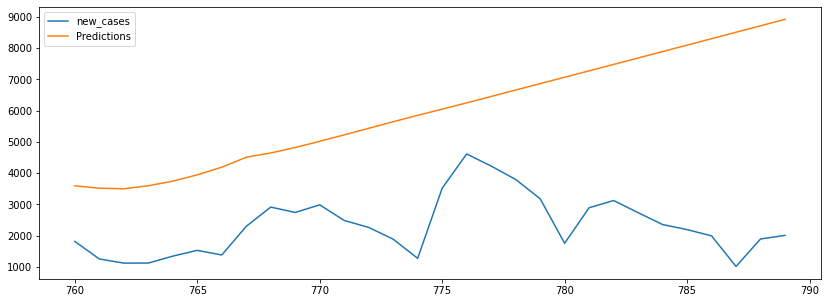

In [57]:
test.plot(figsize=(14,5))


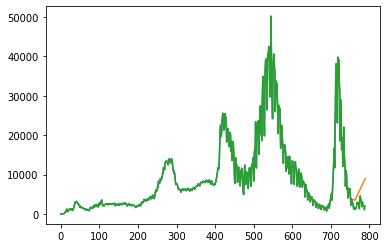

In [58]:
plt.plot(train.index, train['new_cases'])
plt.plot(test.index, test['Predictions'])
plt.plot(df.index, df['new_cases'])

In [60]:
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)

LOOK_BACK = 14

In [62]:
X_train, y_train = create_dataset(scaled_train,LOOK_BACK)
X_test, y_test = create_dataset(scaled_test,LOOK_BACK)

In [64]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [65]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer="adam",loss='mse')
    return model

model_bilstm = create_bilstm(64)
    # Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer="adam",loss="mse")
    return model
model_gru = create_gru(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

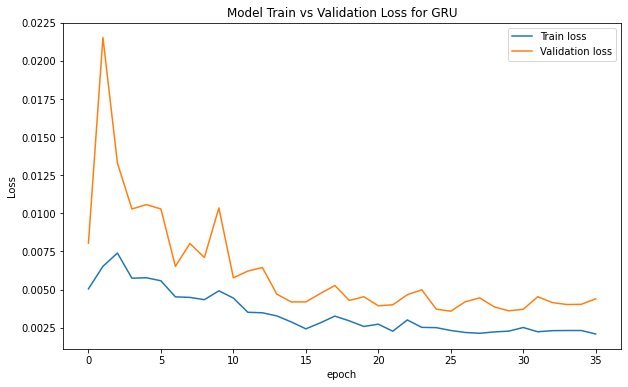

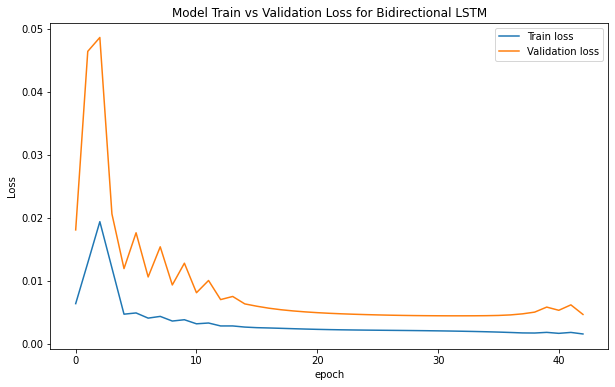

In [67]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

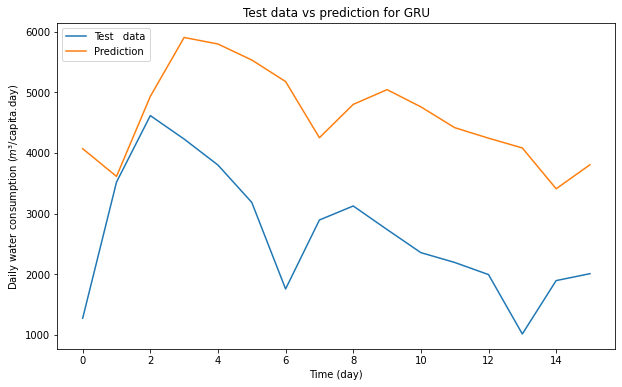

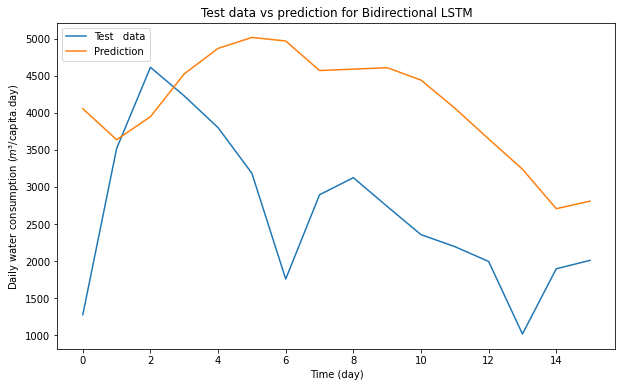

In [68]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')    
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m³$/capita.day)')
 

inv_y = scaler.inverse_transform(y_test)
plot_future(prediction_gru, 'GRU', inv_y)
plot_future(prediction_bilstm, 'Bidirectional LSTM', inv_y)